In [1]:
import torch as T
from torch.optim import Adam, SGD
from torch import nn
from model.classifier import Classifier, Epoch, train
import pandas as pd
from pathlib import Path
import warnings
import numpy as np
import seaborn as sns

In [2]:
warnings.filterwarnings('ignore')

In [3]:
from sklearn.preprocessing import Normalizer


class ClassifierDataset(T.utils.data.Dataset):
    def __init__(self, dataframe, target, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.dataframe = dataframe
        self.target = target
        self.features = dataframe.columns.drop(target)

    def __getitem__(self, index):
        scaler = Normalizer()
        item = self.dataframe.iloc[index]
        features = np.float32(item[self.features].to_numpy())
        labels = np.float32(item[self.target])
        # print(features)
        return features, labels

    def __len__(self):
        return len(self.dataframe)

In [4]:
DATA_ROOT = Path('data', 'employee', 't_Employee.csv')
data = pd.read_csv(DATA_ROOT)
target = 'LeaveOrNot'

data.head()

,Education,JoiningYear,PaymentTier,Age,ExperienceInCurrentDomain,LeaveOrNot,Gender_Female,Gender_Male,EverBenched_No,EverBenched_Yes,City_Bangalore,City_New Delhi,City_Pune
0,0,1,3,34,0,0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
1,0,5,1,28,3,1,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0,4,3,38,2,0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
3,1,2,3,27,5,1,0.0,1.0,1.0,0.0,1.0,0.0,0.0
4,1,1,3,24,2,1,0.0,1.0,0.0,1.0,0.0,0.0,1.0


# Train x Test split

100%|██████████| 100/100 [00:26<00:00,  3.74it/s]

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], grad_fn=<RoundBackward0>)


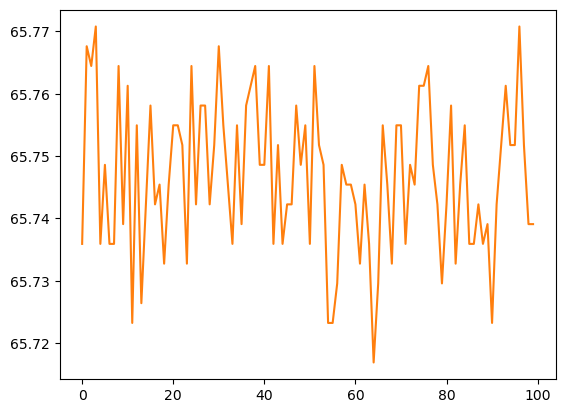

In [9]:
loader_test = ClassifierDataset(dataframe=data, target=target)

train_data, test_data, val_data = T.utils.data.random_split(
    dataset=loader_test, lengths=[0.7, 0.2, 0.1], generator=T.Generator(device="cpu")
)

train_data = T.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_data = T.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

def init_weight(module: nn.Module) -> None:
    if isinstance(module, nn.Linear):
        nn.init.xavier_uniform(module.weight)
        module.bias.data.fill_(0.01)


n_features = data.shape[1] - 1

model = Classifier()


epoch = Epoch()
loss_fn = nn.BCELoss()  # BinaryCrossentropyLoss
optmizer = SGD(params=model.parameters(), lr=10e-2, momentum=.9)

hist = train(
    model=model,
    train_data=train_data,
    val_data=test_data,
    loss_fn=loss_fn,
    optimizer=optmizer,
    n_epochs=100,
)
import matplotlib.pyplot as plt

plt.plot(hist["val_loss"])
plt.plot(hist["train_loss"])